In [139]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
from collections import deque # Import deque for efficient queue operations
import cv2

class imageProcessor1():
    def __init__(self, image_path, x_pix, y_pix, k=0.001):  # Increased k to allow more pixels
        self.readImage1(image_path)
        self.row, self.col = self.ds.shape  # Image dimensions

        self.img_intent = self.ds.astype(np.float32)  # Ensure float type before normalization
        self.img_intent = (self.img_intent - self.img_intent.min()) / (self.img_intent.max() - self.img_intent.min())  # Normalize between 0 and 1

        


        self.mask = np.zeros((self.row, self.col), dtype=np.uint8)  # Empty mask (0s)

        self.seed_row = y_pix  # Seed pixel coordinates
        self.seed_col = x_pix

        self.k = k  # Scaling factor for standard deviation

        # Initialize region statistics
        seed_intensity = self.img_intent[self.seed_row, self.seed_col]
        self.region_pixels = [seed_intensity]
        self.region_mean = seed_intensity  # Initial mean is just the seed pixel intensity
        self.region_std = 0.002  # Start with a small but nonzero
        self.region_var = 0.0004  # Small starting variance (std^2)
        self.region_size = 1  # Track pixel count

        print(f"Seed intensity: {self.img_intent[self.seed_row, self.seed_col]}")
        print(f"Image min: {self.img_intent.min()}, max: {self.img_intent.max()}")


    def readImage1(self, img_path):
        # This function reads a DICOM image from the specified file path.
        # Extracts the pixel array from the image and stores it as `self.ds`.

        img = dicom.dcmread(img_path)  # Read the DICOM file
        self.ds = img.pixel_array  # Extract the pixel array from the DICOM image

    def regionGrowing1(self):
        queue = deque([(self.seed_row, self.seed_col)])  # Use deque instead of list
        neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
        self.img_intent = cv2.bilateralFilter(self.img_intent.astype(np.float32), d=4, sigmaColor=0.1, sigmaSpace=10) #edge preserve filter
        self.mask[self.seed_row, self.seed_col] = 255  # Mark seed pixel as processed

        while queue:
            x, y = queue.popleft()  

            for dx, dy in neighbors:
                nx, ny = x + dx, y + dy


                if 0 <= nx < self.row and 0 <= ny < self.col and self.mask[nx, ny] == 0:
                    patch = self.img_intent[max(0, nx-1):min(self.row, nx+2), max(0, ny-1):min(self.col, ny+2)]
                    pixel_value = np.mean(patch)


                    local_mean = np.mean(self.img_intent[max(0, x-3):min(self.row, x+3), max(0, y-3):min(self.col, y+3)])
                    # Compute std threshold
                    if self.region_size < 1000:
                        std_threshold = 0.03  # Allow faster early expansion
                    else:
                        std_threshold = max(self.k * np.sqrt(self.region_var), 0.005)

                    if abs(pixel_value - self.region_mean) <= std_threshold:
                        self.mask[nx, ny] = 255  # Add pixel to region
                        queue.append((nx, ny))

                        # Incremental mean & variance update
                        self.region_size += 1
                        delta = pixel_value - self.region_mean
                        self.region_mean += delta / self.region_size
                        self.region_var += delta * (pixel_value - self.region_mean) / self.region_size

        self.mask = cv2.morphologyEx(self.mask, cv2.MORPH_CLOSE, np.ones((10,10), np.uint8))  # Fill small holes
        self.mask = cv2.morphologyEx(self.mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))   # Remove noise
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(self.mask)

            # Keep only the largest region (besides background)
        areas = stats[1:, cv2.CC_STAT_AREA]
        if len(areas) > 0:
            max_label = 1 + np.argmax(areas)
            self.mask = np.uint8(labels == max_label) * 255
        print(f"Total pixels added: {self.region_size}")




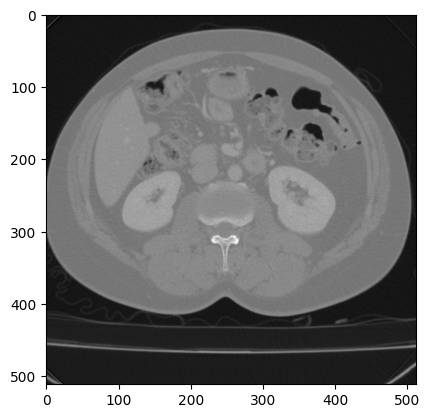

In [93]:
ds = dicom.dcmread('CT_data/i0094,0000b.dcm')
plt.imshow(ds.pixel_array, 'gray')

Seed intensity: 0.5672215223312378
Image min: 0.0, max: 1.0
Total pixels added: 5316


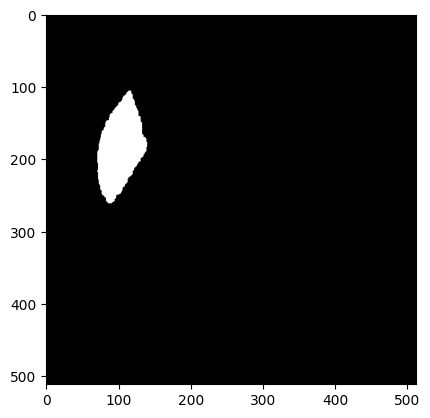

In [140]:
image__1 = imageProcessor1('CT_data/i0095,0000b.dcm', 100, 200)

image__1.regionGrowing1()  # Run region growing algorithm


plt.imshow(image__1.mask, cmap='gray')
plt.show()